In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import seaborn as sns
from figurefirst import FigureLayout,mpl_functions
from scipy.optimize import minimize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import odor_stat_calculations as osc
from scipy.spatial.distance import cdist
import multiprocessing as mp
from scipy.ndimage import gaussian_filter
sys.path.append("../")
from itertools import groupby
from operator import itemgetter
from scipy.stats import kurtosis
from cfd_rigolli import Cfd_rigolli
from scipy.interpolate import splprep, splev
from scipy.stats import wasserstein_distance

%load_ext autoreload
%autoreload 2


In [2]:
def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

hws = pd.read_hdf('/home/gorilla/An/data/simulator/hws/hwsDesert.h5') 
cfd = Cfd_rigolli(dirname="../data/rigolli/")

In [3]:
# Check the scaled range of x_coords and y_coords
x_coords = cfd.x_coords
y_coords = cfd.y_coords

print("Scaled x-coords range:", x_coords.min(), x_coords.max())
print("Scaled y-coords range:", y_coords.min(), y_coords.max())


Scaled x-coords range: 5.01283 40.0
Scaled y-coords range: 0.012826 8.0


In [11]:
import h5py
x_coords = cfd.x_coords
y_coords = cfd.y_coords

# Load the data file and get the initial frame
with h5py.File('../data/rigolli/nose_data.mat', 'r') as f:
    data = f['nose'][0, :, :]  # Initial frame or highest concentration
    data[data <= 0] = 1e-20  # Handling zero or negative values
    log_data = np.log10(data)  # Log scale if needed



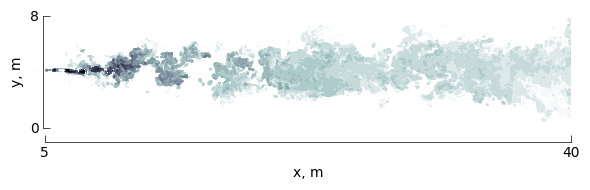

In [12]:
# Create the plot
fig, ax = plt.subplots(figsize=(6, 2))
contour = ax.contourf(x_coords, y_coords, log_data, vmin=-6, vmax=-3, cmap='bone_r', levels=100)
ax.set_xlabel('x, m')
ax.set_ylabel('y, m')
# ax.set_title("Rigolli Dataset")


mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[5,40],
                            yticks=[0,8],
                            linewidth=0.5)
# ax.set_xlim(7, 56)
# ax.set_ylim(0, 30)
fig.tight_layout()

In [13]:
dft = pd.read_hdf('../data/simulator/rigolli/hwsRigolli.h5')

Text(0.5, 1.0, 'Trajectory Scaled and Translated to Target Limits')

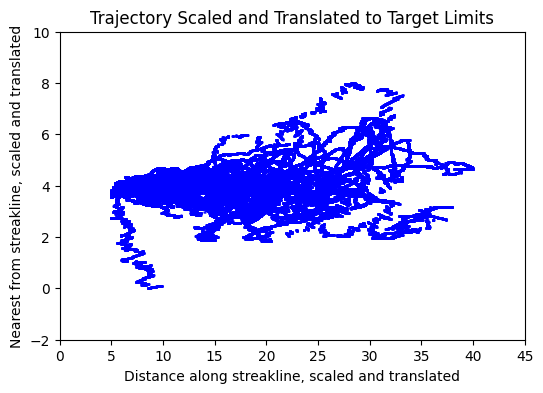

In [14]:
def scale_and_translate(data_x, data_y, target_x_limits, target_y_limits):
    # Step 1: Determine the original range
    original_x_min, original_x_max = min(data_x), max(data_x)
    original_y_min, original_y_max = min(data_y), max(data_y)
    
    # Step 2: Calculate scaling factors to fit the new range
    scale_x = (target_x_limits[1] - target_x_limits[0]) / (original_x_max - original_x_min)
    scale_y = (target_y_limits[1] - target_y_limits[0]) / (original_y_max - original_y_min)
    
    # Apply scaling
    scaled_x = (data_x - original_x_min) * scale_x
    scaled_y = (data_y - original_y_min) * scale_y
    
    # Step 3: Translate the data to match the target limits
    translated_x = scaled_x + target_x_limits[0]
    translated_y = scaled_y + target_y_limits[0]
    
    return translated_x, translated_y

# Assuming your dataset is read into `dft` as shown below:
# dft = pd.read_hdf('/home/gorilla/An/data/simulator/rigolli/hwsRigolli.h5')

# Target limits for the data
target_x_limits = (5, 40)
target_y_limits = (0, 8)

# Scale and translate the data
scaled_translated_x, scaled_translated_y = scale_and_translate(
    dft.distance_along_streakline, 
    dft.nearest_from_streakline, 
    target_x_limits, 
    target_y_limits
)

# Plot the scaled and translated data
f, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(scaled_translated_x, scaled_translated_y, s=1, color='blue', alpha=0.6, label="Scaled and Translated Data")
ax.set_xlim(target_x_limits[0] - 5, target_x_limits[1] + 5)
ax.set_ylim(target_y_limits[0] - 2, target_y_limits[1] + 2)
ax.set_xlabel("Distance along streakline, scaled and translated")
ax.set_ylabel("Nearest from streakline, scaled and translated")
ax.set_title("Trajectory Scaled and Translated to Target Limits")



In [15]:
dft.distance_along_streakline = scaled_translated_x
dft.nearest_from_streakline = scaled_translated_y
dft['odor']=dft.scaled_odor
dft['distance_from_source'] = np.sqrt(dft['distance_along_streakline']**2 + dft['nearest_from_streakline']**2)

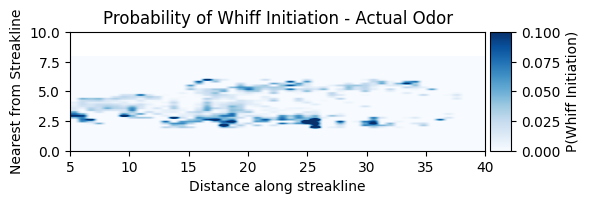

In [16]:
n_bins_x=50
n_bins_y=50
heatmap_whiff, xedges, yedges = np.histogram2d(dft['distance_along_streakline'], 
                                               dft['nearest_from_streakline'], 
                                               bins=[n_bins_x, n_bins_y], 
                                               weights=dft['whiff_flag'])

# Histogram for total data points (irrespective of whiff initiation)
heatmap_total, _, _ = np.histogram2d(dft['distance_along_streakline'], 
                                     dft['nearest_from_streakline'], 
                                     bins=[n_bins_x, n_bins_y])

# Calculate the probability as number of whiff initiation points / total number of data points
with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
    heatmap_prob = np.divide(heatmap_whiff, heatmap_total, out=np.zeros_like(heatmap_whiff), where=heatmap_total != 0)

# Apply smoothing and normalization
# smoothed_heatmap_prob = smooth_heatmap(heatmap_prob, weight=0.2)
# smoothed_prob = normalize_probabilities(smoothed_heatmap_prob)

# Plot the original and smoothed heatmaps
f, (ax1) = plt.subplots(1, 1, figsize=(6, 8))

# Plot original heatmap (number of whiff initiation points / total data points)
cax1 = ax1.imshow(heatmap_prob.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   cmap='Blues', vmin=0,vmax=0.1)
divider1 = make_axes_locatable(ax1)
cbar_ax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax1, cax=cbar_ax1, label='P(Whiff Initiation)')
ax1.set_ylabel('Nearest from Streakline')
ax1.set_xlabel('Distance along streakline')
ax1.set_title('Probability of Whiff Initiation - Actual Odor')
ax1.set_ylim(0,10)
f.tight_layout()

Optimal Parameters:
A = 0.019696952073053622
x0 = 3.0
y0 = 4.0
sigma_x = 35.0
sigma_y = 1.5
theta = 0.0


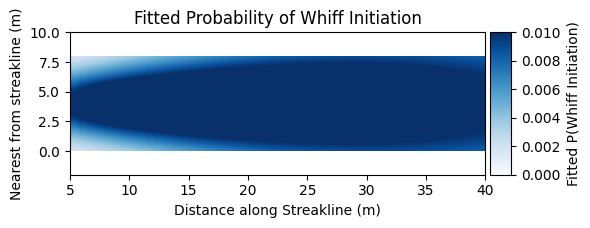

In [17]:
def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_x, base_sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y, damping_factor):
    """Calculate a directional Gaussian plume model with dynamic spread."""
    distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)
    # sigma_x = base_sigma_x + distance_scale_factor_x * distance_from_source
    # sigma_x = base_sigma_x + distance_scale_factor_x * np.log1p(distance_from_source)  # Logarithmic scale for less impact near source
    # sigma_y = base_sigma_y + distance_scale_factor_y * distance_from_source

    sigma_x = base_sigma_x + distance_scale_factor_x * np.sqrt(distance_from_source)
    sigma_y = base_sigma_y + distance_scale_factor_y * distance_from_source 
    
    xp = np.cos(theta) * (x - x0) - np.sin(theta) * (y - y0)
    yp = np.sin(theta) * (x - x0) + np.cos(theta) * (y - y0)

    p = A * np.exp(-((xp)**2 / (2 * sigma_x**2)) - ((yp)**2 / (2 * sigma_y**2))) * np.exp(-damping_factor / (distance_from_source + 1))
    
    # Clip the probabilities to avoid extreme values
    # p = np.clip(p, 0.01, 0.99) 

    return p


# Prepare bin centers (same as before)
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing='ij')

# Flatten arrays
X_flat = X_centers.flatten()
Y_flat = Y_centers.flatten()
k_obs = heatmap_whiff.flatten()
n_obs = heatmap_total.flatten()

# Exclude bins with zero observations
valid_bins = n_obs > 0
X_flat = X_flat[valid_bins]
Y_flat = Y_flat[valid_bins]
k_obs = k_obs[valid_bins]
n_obs = n_obs[valid_bins]


def negative_log_likelihood(params, x, y, k, n):
    A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y,damping_factor = params
    p = directional_gaussian_plume(x, y, A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y,damping_factor)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(ll)


# Adjusted initial parameters for increased vertical spread along the sides
initial_params = [1.0, 5, 4, 40, 2, 0.0, 0.3, 0.05, 1.2]

# Refined bounds to encourage more vertical spread while keeping the conical shape
bounds = [
    (0, 1),        # A ≥ 0
    (3, 5),        # x0 fixed at 0
    (4, 4),        # y0 fixed at 0
    (35, 40),      # sigma_x limited to control horizontal spread
    (1, 1.5),        # sigma_y increased for more vertical spread
    (0, 0),        # theta fixed at 0 for no rotation
    (0.1, 0.3),    # distance_scale_factor_x for controlled horizontal expansion
    (0.01, 0.1),    # distance_scale_factor_y increased for more vertical spread
    (1.8, 2)     # damping_factor for moderate decay
]

# Perform the optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_flat, Y_flat, k_obs, n_obs),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal parameters
optimal_params = result.x
print("Optimal Parameters:")
print(f"A = {optimal_params[0]}")
print(f"x0 = {optimal_params[1]}")
print(f"y0 = {optimal_params[2]}")
print(f"sigma_x = {optimal_params[3]}")
print(f"sigma_y = {optimal_params[4]}")
print(f"theta = {optimal_params[5]}")

# Compute fitted probabilities50
fitted_p = directional_gaussian_plume(
    X_centers, Y_centers, *optimal_params
)
fitted_p_heatmap = fitted_p.reshape((len(x_centers), len(y_centers)))

# Plotting
f,ax=plt.subplots(1,1,figsize=(6, 6))
cax =ax.imshow(
    fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0,vmax=0.01
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='Fitted P(Whiff Initiation)')
ax.set_xlabel('Distance along Streakline (m)')
ax.set_ylabel('Nearest from streakline (m)')
ax.set_title('Fitted Probability of Whiff Initiation')
ax.set_ylim(-2,10)
f.tight_layout()

/tmp/ipykernel_101786/638884725.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])
/tmp/ipykernel_101786/638884725.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''])


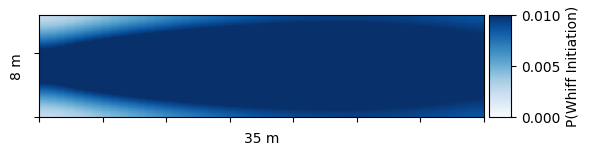

In [18]:
from scipy.ndimage import gaussian_filter

def smooth_heatmap_adjustment(heatmap, region_mask, adjustment_factor, sigma=1.0):
    # Apply the adjustment to the specified region
    adjusted_heatmap = heatmap.copy()
    adjusted_heatmap[region_mask] *= adjustment_factor
    smoothed_heatmap = gaussian_filter(adjusted_heatmap, sigma=sigma)
    
    return smoothed_heatmap

region_mask = (X_centers > 15) & (X_centers < 20)  # Adjust region between 10m and 15m along the streakline
adjustment_factor = 1  # Reduce probability by 20% in this region
sigma_smoothing = 2.0  # Gaussian smoothing standard deviation

# Smoothly adjust the fitted probability heatmap
smoothed_fitted_p_heatmap = smooth_heatmap_adjustment(fitted_p_heatmap, region_mask, adjustment_factor, sigma=sigma_smoothing)

# Plot the smoothed adjusted heatmap
f, ax = plt.subplots(1, 1, figsize=(6, 10))
cax = ax.imshow(
    smoothed_fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0, vmax=0.01
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='P(Whiff Initiation)')
# ax.set_xlabel('Distance along Streakline (m)')
# ax.set_ylabel('Nearest from\nstreakline (m)')
# ax.set_title('Smoothed Adjusted Fitted Probability of Whiff Initiation')
ax.set_xlabel('35 m')
ax.set_ylabel('8 m')
ax.set_xticklabels([''])
ax.set_yticklabels([''])


f.tight_layout()



In [19]:
def avg_distance(df,index,dat): #input ; location ; storage
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i<len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i+=1
    dat['avg_distance_along_streakline']= distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def get_index_nowhiff(data, th):
    idx = [i for i, value in enumerate(data) if value < th]
    index = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]
    return index

def avg_distance_nowhiff(df, idx, dat):
    distance_along_streakline = []
    nearest_from_streakline = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            distance_along_streakline.append(np.mean(df['distance_along_streakline'].iloc[indices]))
            nearest_from_streakline.append(np.mean(df['nearest_from_streakline'].iloc[indices]))
        else:
            distance_along_streakline.append(np.nan)
            nearest_from_streakline.append(np.nan)

    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def wc_wsd_nowhiff(df, idx, dat):
    wc_nowhiff = []
    std_dev_nowhiff = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            wc_nowhiff.append(np.mean(df['odor'].iloc[indices]))
            std_dev_nowhiff.append(np.std(df['odor'].iloc[indices]))
        else:
            wc_nowhiff.append(np.nan)
            std_dev_nowhiff.append(np.nan)

    dat['wc_nowhiff'] = wc_nowhiff
    dat['wsd_nowhiff'] = std_dev_nowhiff

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

th = 6.5
np.seterr(divide='ignore')
index = osc.get_index(dft.odor,th)
index_nowhiff = get_index_nowhiff(dft.odor,th)
fdf = pd.DataFrame()
fdf_nowhiff=pd.DataFrame()

cal_stat(dft,index,fdf)
avg_distance(dft, index, fdf)
wc_wsd_nowhiff(dft, index_nowhiff,fdf_nowhiff)
avg_distance_nowhiff(dft,index_nowhiff,fdf_nowhiff)


In [20]:
df_test=dft.copy()

In [21]:
df_test=dft[10000:]
df_test.reset_index(inplace=True, drop=True)
dt=df_test.time[1]-df_test.time[0]
time = []
time.append(0)
for i in range(1,len(df_test)):
    time.append(time[i-1]+dt)
    
df_test['time'] = time


def predict_whiff_from_probability(x, y, hmap, xedges, yedges):
    x_bin = np.digitize(x, xedges) - 1  # -1 because digitize returns 1-based index
    y_bin = np.digitize(y, yedges) - 1

    if x_bin < 0 or x_bin >= hmap.shape[0] or y_bin < 0 or y_bin >= hmap.shape[1]:
        return False, 0  # No valid bin, so no whiff predicted, probability is 0
    whiff_prob = hmap[x_bin, y_bin]
    whiff_predicted = np.random.rand() < whiff_prob  # True if random number is less than the probability

    return whiff_predicted, whiff_prob

/tmp/ipykernel_101786/599951331.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['time'] = time


In [22]:
distance_threshold = 4
rows_per_second = 200
base_odor_level = 0.58 

odor_concentration_samples = np.full(len(df_test), base_odor_level)
whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values

whiff_means = fdf.mean_concentration.values
whiff_stds = fdf.std_whiff.values
whiff_duration = fdf.length_of_encounter.values
nowhiff_means = fdf_nowhiff.wc_nowhiff.values
nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

In [23]:
distances = cdist(test_locations, whiff_locations)
distances_nowhiff = cdist(test_locations,nowhiff_locations )

In [24]:
fitted_p_heatmap_1=smoothed_fitted_p_heatmap*1.1

In [63]:
# def moving_average(data, window_size):
#     if window_size < 1 or len(data) < window_size:
#         return data  # Return data as is if the window size is too large for the data length
#     window = np.ones(int(window_size))/float(window_size)
#     return np.convolve(data, window, 'same')

# i = 0
# while i < len(df_test):
#     dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
#     whiff_predicted, whiff_prob = predict_whiff_from_probability(dist_along, nearest_from, 
#                                                                  fitted_p_heatmap_1, xedges, yedges)
#     # whiff_predicted, whiff_prob = predict_whiff_from_probability(dist_along, nearest_from, interpolator)
    
#     if whiff_predicted and np.min(distances[i]) <= distance_threshold:
#         nearest_whiff_idx = np.argmin(distances[i])
#         mean_concentration = whiff_means[nearest_whiff_idx]
#         std_dev_whiff = whiff_stds[nearest_whiff_idx]
#         duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
#         rows_to_fill = min(duration, len(df_test) - i)

#         generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
#         generated_concentrations = np.clip(generated_concentrations, 6, 10.2)
#         odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
#         whiff_prediction_samples[i:i + rows_to_fill] = 1
#         i += rows_to_fill  # Move index by the number of filled rows
#     else:
#         i += 1  

# # Step 2: Address No Whiff Regions
# i = 0
# while i < len(df_test):
#     if odor_concentration_samples[i] == base_odor_level:
#         nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
#         no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
#         no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

#         start = i
#         while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
#             i += 1
#         end = i

#         no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
#         no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)  # Ensure values are within realistic bounds
#         # odor_concentration_samples[start:end] = no_whiff_concentrations
#         # Apply moving average smoothing
#         smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)

#         odor_concentration_samples[start:end] = smoothed_concentrations
#     else:
#         i += 1

# # Update the DataFrame with the results
# df_test['predicted_odor'] = odor_concentration_samples
# df_test['whiff_predicted'] = whiff_prediction_samples

In [75]:
class OdorPredictor:
    def __init__(self, fitted_p_heatmap, xedges, yedges, fdf, fdf_nowhiff, distance_threshold=4, rows_per_second=200, base_odor_level=0.58):
        self.fitted_p_heatmap = fitted_p_heatmap
        self.xedges = xedges
        self.yedges = yedges
        self.distance_threshold = distance_threshold
        self.rows_per_second = rows_per_second
        self.base_odor_level = base_odor_level
        self.initialize_data(fdf, fdf_nowhiff)

    def initialize_data(self, fdf, fdf_nowhiff):
        # Extract necessary data as arrays for faster access
        self.whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
        self.nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
        self.whiff_means = fdf.mean_concentration.values
        self.whiff_stds = fdf.std_whiff.values
        self.whiff_duration = fdf.length_of_encounter.values
        self.nowhiff_means = fdf_nowhiff.wc_nowhiff.values
        self.nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

    def predict_whiff_from_probability(self, x, y):
        x_bin = np.digitize(x, self.xedges) - 1
        y_bin = np.digitize(y, self.yedges) - 1
        if x_bin < 0 or x_bin >= self.fitted_p_heatmap.shape[0] or y_bin < 0 or y_bin >= self.fitted_p_heatmap.shape[1]:
            return False, 0
        whiff_prob = self.fitted_p_heatmap[x_bin, y_bin]
        return np.random.rand() < whiff_prob, whiff_prob

    @staticmethod
    def moving_average(data, window_size=5):
        # Adjust moving average to keep the same length as input data
        return np.convolve(data, np.ones(window_size)/window_size, mode='same')

    def predict_odor_concentration(self, x, y):
        # Convert DataFrame columns to NumPy arrays
        df_test = pd.DataFrame({'distance_along_streakline': x, 'nearest_from_streakline': y})
        odor_concentration_samples = np.full(len(df_test), self.base_odor_level)
        whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

        test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
        distances = cdist(test_locations, self.whiff_locations)
        distances_nowhiff = cdist(test_locations, self.nowhiff_locations)

        # Process whiff and no-whiff regions
        odor_concentration_samples, whiff_prediction_samples = self.process_whiff_regions(
            distances, odor_concentration_samples, whiff_prediction_samples, test_locations
        )
        odor_concentration_samples = self.process_no_whiff_regions(
            distances_nowhiff, odor_concentration_samples
        )

        # Return results as DataFrame
        df_test['predicted_odor'] = odor_concentration_samples
        df_test['whiff_predicted'] = whiff_prediction_samples
        return df_test

    def process_whiff_regions(self, distances, odor_concentration_samples, whiff_prediction_samples, test_locations):
        for i, (dist_along, nearest_from) in enumerate(test_locations):
            whiff_predicted, _ = self.predict_whiff_from_probability(dist_along, nearest_from)
            if whiff_predicted and np.min(distances[i]) <= self.distance_threshold:
                nearest_whiff_idx = np.argmin(distances[i])
                mean_concentration = self.whiff_means[nearest_whiff_idx]
                std_dev_whiff = self.whiff_stds[nearest_whiff_idx]
                duration = int(self.whiff_duration[nearest_whiff_idx] * self.rows_per_second)
                rows_to_fill = min(duration, len(odor_concentration_samples) - i)

                generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
                generated_concentrations = np.clip(generated_concentrations, 4, 10.2)
                odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
                whiff_prediction_samples[i:i + rows_to_fill] = 1
        return odor_concentration_samples, whiff_prediction_samples

    def process_no_whiff_regions(self, distances_nowhiff, odor_concentration_samples):
        i = 0
        while i < len(odor_concentration_samples):
            if odor_concentration_samples[i] == self.base_odor_level:
                nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
                no_whiff_mean = self.nowhiff_means[nearest_no_whiff_idx]
                no_whiff_std = self.nowhiff_wsd[nearest_no_whiff_idx]

                start = i
                while i < len(odor_concentration_samples) and odor_concentration_samples[i] == self.base_odor_level:
                    i += 1
                end = i

                no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
                no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)
                
                # Check if moving average should be applied
                if end - start >= 5:  # Apply only if length >= window size
                    smoothed_concentrations = self.moving_average(no_whiff_concentrations, window_size=5)
                    odor_concentration_samples[start:end] = smoothed_concentrations[:end - start]
                else:
                    odor_concentration_samples[start:end] = no_whiff_concentrations
            else:
                i += 1
        return odor_concentration_samples

# if __name__ == "__main__":
    # t = time.time()
    # dirname = '../data/simulator/hws/'
    # hmap_data = np.load(str(dirname) + "hmap_with_edges.npz")
    
    # predictor = OdorPredictor(
    #     fitted_p_heatmap=fitted_p_heatmap_1,
    #     xedges=xedges,
    #     yedges=yedges,
    #     fdf=fdf,
    #     fdf_nowhiff=fdf_nowhiff
    # )
    
    # x = df_test.distance_along_streakline.values
    # y = df_test.nearest_from_streakline.values
    
    # pdf = predictor.predict_odor_concentration(x, y)


In [76]:
# df_test['predicted_odor']=pdf.predicted_odor
# df_test['whiff_predicted']=pdf.whiff_predicted
predictor = OdorPredictor(
    fitted_p_heatmap=fitted_p_heatmap_1,
    xedges=xedges,
    yedges=yedges,
    fdf=fdf,
    fdf_nowhiff=fdf_nowhiff
)


In [25]:
def growing_sine_wave_from_point(x_start, y_start, start_amplitude, start_wavelength, duration=10, num_points=100, amplitude_growth_rate=0.1, wavelength_growth_rate=0.05):
    """Generate a growing sinusoidal trajectory."""
    time = np.linspace(x_start, x_start - duration, num_points)  # Move toward 0
    amplitude = start_amplitude + amplitude_growth_rate * (x_start - time)  # Grow amplitude
    wavelength = start_wavelength + wavelength_growth_rate * (x_start - time)  # Grow wavelength
    frequency = 1 / wavelength
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * (x_start - time)) + y_start

    return time, sine_wave, amplitude[-1], wavelength[-1]


def plot_trajectory(all_time, all_sine_wave, detected_times, detected_sine_waves, source):
    """Visualizes the agent's trajectory."""
    f,ax = plt.subplots(figsize=(6, 4))
    ax.plot(all_time, all_sine_wave, label='Agent Trajectory', color='black')
    ax.scatter(detected_times, detected_sine_waves, color='red', label='Odor Detected', zorder=5)
    ax.scatter(source[0], source[1], color='blue', label='Source', s=100, zorder=10)
    ax.set_xlabel("Distance along streakline, m")
    ax.set_ylabel("Nearest from streakline")
    ax.legend()
    ax.grid(False)
    f.tight_layout()

In [84]:
def trajectory_to_targets(x_start, y_start, source, simulator, threshold, radius=1, duration=10, num_points=200, 
                          amplitude_growth_rate=0.1, wavelength_growth_rate=0.05, max_steps=100):
    """
    Implements the cast-and-surge behavior for the agent with proper distance-based stopping at (0, 0).
    """
    # Initialize variables
    current_x, current_y = x_start, y_start
    all_time, all_sine_wave = [], []
    detected_times, detected_sine_waves = [], []
    odor_series, time_series = [], []  # Store continuous odor concentrations and time
    last_amplitude, last_wavelength = 1, 1  # Initial amplitude and wavelength
    step_count = 0
    is_surging = False
    current_time = 0  # Start time counter
    time_step = 0.1  # Fixed time increment per step

    while step_count < max_steps:
        if is_surging:
            # Surge phase: Move straight along the x-axis
            surge_distance = 5  # Maximum distance to move
            surge_steps = int(surge_distance / time_step)
            surge_time = np.linspace(current_x, max(current_x - surge_distance, source[0]), surge_steps)
            surge_wave = np.full_like(surge_time, current_y)  # Keep y constant

            # Predict odor and store results
            predicted_data = simulator.predict_odor_concentration(surge_time, surge_wave)
            odor_series.extend(predicted_data['predicted_odor'])
            time_series.extend([current_time + i * time_step for i in range(len(surge_time))])

            # Update the time counter continuously
            current_time += time_step * len(surge_time)

            # Check for termination or odor detection
            for idx, (x, y) in enumerate(zip(surge_time, surge_wave)):
                distance_to_source = np.sqrt((x - source[0])**2 + (y - source[1])**2)
                if distance_to_source < radius:
                    print(f"Source reached at ({x:.2f}, {y:.2f}). Stopping.")
                    all_time.extend(surge_time[:idx + 1])
                    all_sine_wave.extend(surge_wave[:idx + 1])
                    return all_time, all_sine_wave, detected_times, detected_sine_waves, time_series, odor_series

            detected_indices = np.where(predicted_data['predicted_odor'] >= threshold)[0]
            if len(detected_indices) > 0:
                first_detection_idx = detected_indices[0]
                detected_x = surge_time[first_detection_idx]
                detected_y = surge_wave[first_detection_idx]

                # Update trajectory and position
                current_x, current_y = detected_x, detected_y
                all_time.extend(surge_time[:first_detection_idx + 1])
                all_sine_wave.extend(surge_wave[:first_detection_idx + 1])
                print(f"Odor detected during surge at ({detected_x:.2f}, {detected_y:.2f}). Continuing surge.")
                continue

            # No odor detected: Update position
            all_time.extend(surge_time)
            all_sine_wave.extend(surge_wave)
            current_x, current_y = surge_time[-1], surge_wave[-1]
            is_surging = False

        else:
            # Casting phase: Generate sinusoidal trajectory
            temp_time, temp_sine_wave, last_amplitude, last_wavelength = growing_sine_wave_from_point(
                current_x, current_y, last_amplitude, last_wavelength, duration, num_points, amplitude_growth_rate, wavelength_growth_rate
            )

            # Predict odor and store results
            predicted_data = simulator.predict_odor_concentration(temp_time, temp_sine_wave)
            odor_series.extend(predicted_data['predicted_odor'])
            time_series.extend([current_time + i * time_step for i in range(len(temp_time))])

            # Update the time counter continuously
            current_time += time_step * len(temp_time)

            # Check for termination or odor detection
            for idx, (x, y) in enumerate(zip(temp_time, temp_sine_wave)):
                distance_to_source = np.sqrt((x - source[0])**2 + (y - source[1])**2)
                if distance_to_source < radius:
                    print(f"Source reached at ({x:.2f}, {y:.2f}). Stopping.")
                    all_time.extend(temp_time[:idx + 1])
                    all_sine_wave.extend(temp_sine_wave[:idx + 1])
                    return all_time, all_sine_wave, detected_times, detected_sine_waves, time_series, odor_series

            detected_indices = np.where(predicted_data['predicted_odor'] >= threshold)[0]
            if len(detected_indices) > 0:
                first_detection_idx = detected_indices[0]
                detected_x = temp_time[first_detection_idx]
                detected_y = temp_sine_wave[first_detection_idx]

                # Update trajectory and position
                current_x, current_y = detected_x, detected_y
                all_time.extend(temp_time[:first_detection_idx + 1])
                all_sine_wave.extend(temp_sine_wave[:first_detection_idx + 1])
                detected_times.append(detected_x)
                detected_sine_waves.append(detected_y)
                print(f"Odor detected during casting at ({detected_x:.2f}, {detected_y:.2f}). Switching to surge phase.")
                is_surging = True
                continue

            # No odor detected: Update position
            all_time.extend(temp_time)
            all_sine_wave.extend(temp_sine_wave)
            current_x, current_y = temp_time[-1], temp_sine_wave[-1]

        # Increment step count
        step_count += 1

    return all_time, all_sine_wave, detected_times, detected_sine_waves, time_series, odor_series

In [82]:
np.array([40,4])

array([40,  4])

In [85]:
predictor.predict_odor_concentration(np.array([40]), np.array([4]))['predicted_odor']

0    0.58
Name: predicted_odor, dtype: float64

In [86]:
cfd.get_odor_at_position_and_time((40, 4), 20)

array(14.49547496)

Odor detected during casting at (39.88, 4.69). Switching to surge phase.
Odor detected during casting at (32.90, 6.89). Switching to surge phase.
Odor detected during casting at (26.57, 4.47). Switching to surge phase.
Odor detected during surge at (21.78, 4.47). Continuing surge.
Odor detected during surge at (21.27, 4.47). Continuing surge.
Odor detected during surge at (18.31, 4.47). Continuing surge.
Odor detected during surge at (14.23, 4.47). Continuing surge.
Odor detected during surge at (12.59, 4.47). Continuing surge.
Source reached at (5.05, 3.64). Stopping.


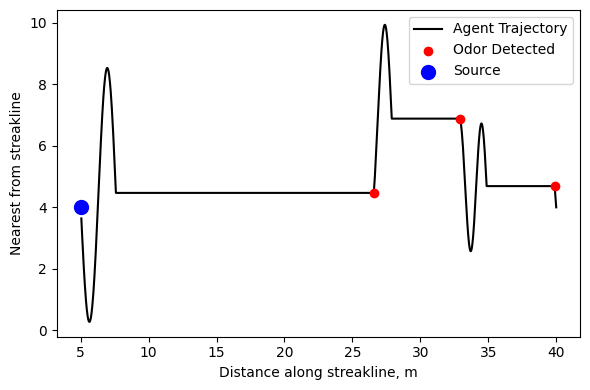

In [87]:
# Parameters for the simulation
x_start, y_start = 40, 4  # Starting position
source = (5, 4)           # Source position
threshold = 4.5           # Odor detection threshold
radius = 0.5                # Detection radius
duration = 10             # Casting duration
num_points = 500          # Points per trajectory segment
max_steps = 50            # Maximum number of iterations

# Run the cast-and-surge algorithm
all_time, all_sine_wave, detected_times, detected_sine_waves, time_counter, odor_series, = trajectory_to_targets(
    x_start, y_start, source, predictor, threshold, radius, duration, num_points, max_steps=max_steps
)
# Plot the trajectory
plot_trajectory(all_time, all_sine_wave, detected_times, detected_sine_waves, source)

Text(0, 0.5, 'odor, a.u.')

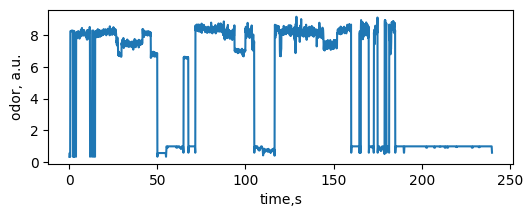

In [90]:
f,ax=plt.subplots(1,1,figsize=(6,2))
ax.plot(time_counter,odor_series)
ax.set_xlabel('time,s')
ax.set_ylabel('odor, a.u.')

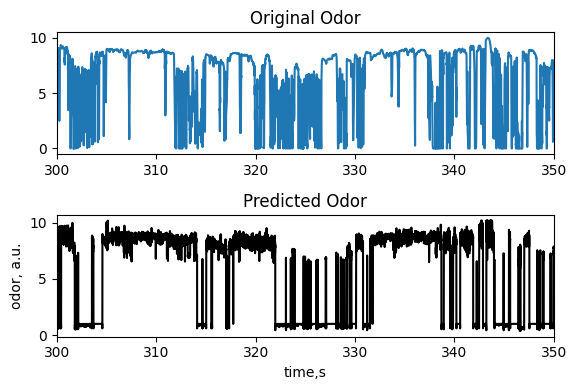

In [67]:
f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
ax1.plot(df_test.time, df_test.odor, label='original')
ax2.plot(df_test.time, df_test.predicted_odor, label='predicted', c='black')

limit = (300,350)
ax1.set_xlim(limit)
ax2.set_xlim(limit)

ax2.set_ylabel('odor, a.u.')
ax2.set_xlabel('time,s')
ax1.set_title('Original Odor')
ax2.set_title('Predicted Odor')
f.tight_layout()

In [68]:
th=6.5
query1 = 'odor>'+str(th)
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>'+str(th)
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)

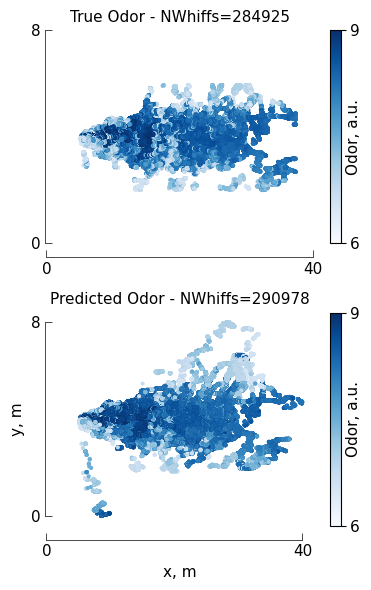

In [72]:
f, ax = plt.subplots(2, 1, figsize=(4, 6))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=6, vmax=9)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=6, vmax=9)
# cax3 = ax[2].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)


# ylim=(-15,25)

ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))
# ax[2].set_title('Whiff Onset Locations')
ax[1].set_xlabel('x, m')
ax[1].set_ylabel('y, m')

cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
# cb3=plt.colorbar(cax3)

cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=-10)
# cb3.set_label('P(Whiff Onset)',labelpad=-10)

cb1.set_ticks([6,9])
cb2.set_ticks([6,9])
# cb3.set_ticks([0, 1])
for i in range(2):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,40],
                            yticks=[0,8],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],11)

f.tight_layout()

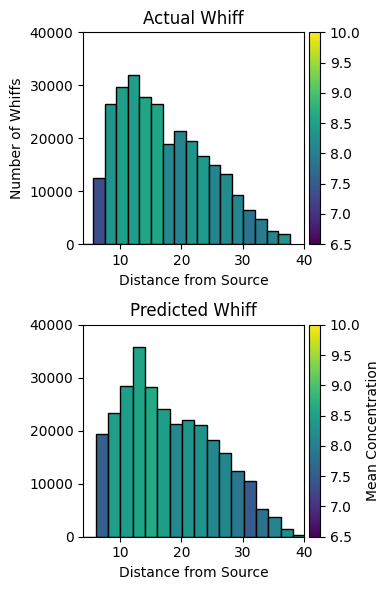

In [73]:
n_bins = 20

# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Handle NaN values in mean concentrations
mean_concentrations_actual = mean_concentrations_actual.fillna(0)  # Replace NaN with 0
mean_concentrations_predicted = mean_concentrations_predicted.fillna(0)

# Create the subplots
f, ax = plt.subplots(2, 1, figsize=(4, 6))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(6.5, 10)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)
# cbar_actual.set_label('Mean Concentration')

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('Number of Whiffs')
ax[0].set_title('Actual Whiff')
ax[0].set_ylim(0,40000)
ax[0].set_xlim(4,40)
# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(6.5, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
ax[1].set_ylim(0,40000)
ax[1].set_xlim(4,40)
f.tight_layout()

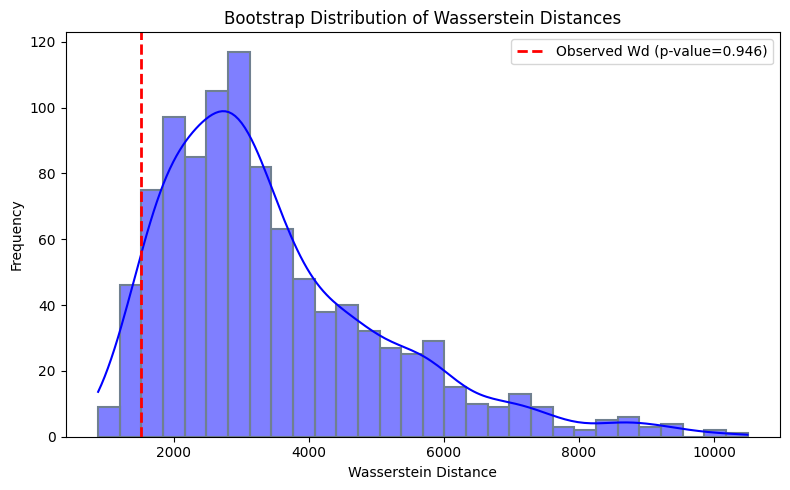

In [74]:
true_data = whiff_counts_actual.values  # Actual whiff counts
predicted_data = whiff_counts_predicted.values
# Calculate the observed Wasserstein distance
observed_wd = wasserstein_distance(true_data, predicted_data)

# Define the function to calculate bootstrap Wasserstein distances
def bootstrap_wasserstein(true_data, predicted_data, n_bootstraps=1000):
    combined_data = np.concatenate([true_data, predicted_data])
    bootstrap_distances = []
    for _ in range(n_bootstraps):
        bootstrap_true = np.random.choice(combined_data, size=len(true_data), replace=True)
        bootstrap_predicted = np.random.choice(combined_data, size=len(predicted_data), replace=True)
        bootstrap_distances.append(wasserstein_distance(bootstrap_true, bootstrap_predicted))
    return bootstrap_distances

# Perform bootstrap sampling
n_bootstraps = 1000
bootstrap_distances = bootstrap_wasserstein(true_data, predicted_data, n_bootstraps)

# Calculate the p-value
p_value = np.mean(np.array(bootstrap_distances) >= observed_wd)

# Plot the bootstrap distribution
plt.figure(figsize=(8, 5))
sns.histplot(bootstrap_distances, bins=30, kde=True, color='blue', edgecolor='slategray', linewidth=1.5)
plt.axvline(observed_wd, color='red', linestyle='--', linewidth=2, label=f'Observed Wd (p-value={p_value:.3f})')
plt.title('Bootstrap Distribution of Wasserstein Distances')
plt.xlabel('Wasserstein Distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.tight_layout()

In [75]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 6.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

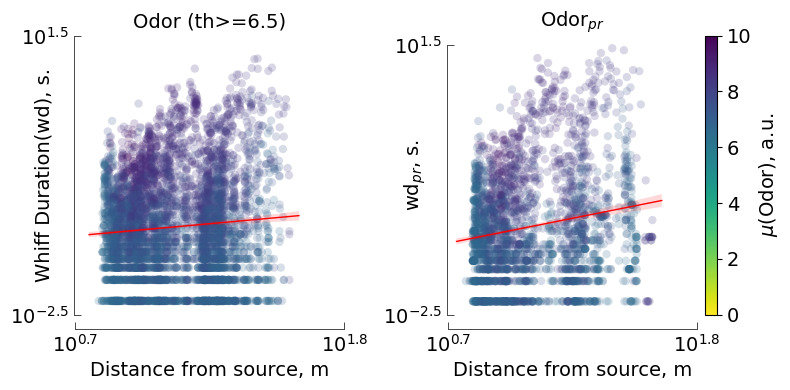

In [76]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf1.log_avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10)
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source,y=fdf1.log_whiff , data=fdf1,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('Whiff Duration(wd), s.')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.log_avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(Odor), a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0.7,1.8],
                            yticks=[-2.5,1.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0.7,1.8],
                            yticks=[-2.5,1.5],
                            linewidth=0.5)
ax1.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.5}$'])
ax1.set_xticklabels([r'$10^{0.7}$',r'$10^{1.8}$'])
ax2.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.5}$'])
ax2.set_xticklabels([r'$10^{0.7}$',r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()


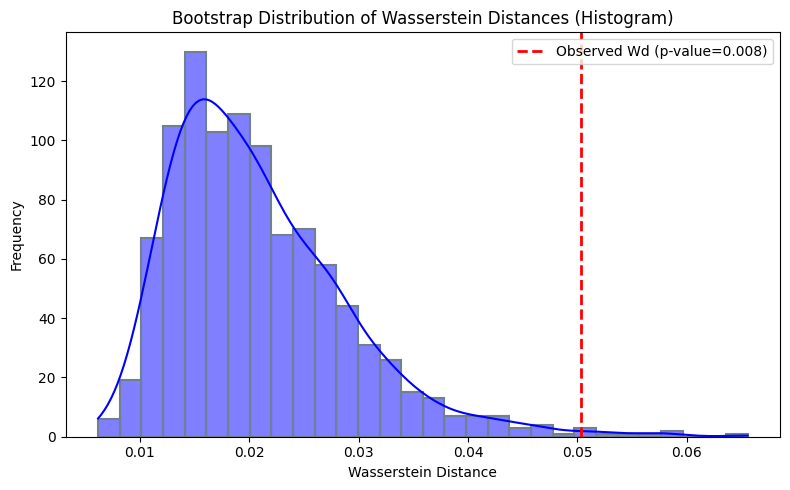

In [77]:
# Calculate observed Wasserstein distance
observed_wd = wasserstein_distance(fdf.log_whiff, fdf_predicted.log_whiff)

# Bootstrapping for histogram-based comparison
bootstrap_distances = bootstrap_wasserstein(fdf.log_whiff, fdf_predicted.log_whiff, n_bootstraps=1000)
p_value = np.mean(np.array(bootstrap_distances) >= observed_wd)
# Plot bootstrap results
plt.figure(figsize=(8, 5))
sns.histplot(bootstrap_distances, bins=30, kde=True, color='blue', edgecolor='slategray', linewidth=1.5)
plt.axvline(observed_wd, color='red', linestyle='--', linewidth=2, label=f'Observed Wd (p-value={p_value:.3f})')
plt.title('Bootstrap Distribution of Wasserstein Distances (Histogram)')
plt.xlabel('Wasserstein Distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.tight_layout()

(0.0, 650.0)

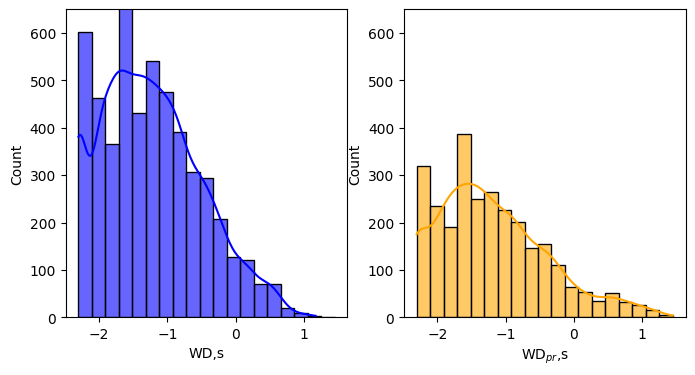

In [80]:
f,(ax1,ax2)=plt.subplots(1,2, figsize=(8, 4))

sns.histplot(fdf1['log_whiff'], bins=bins, color='blue', alpha=0.6, label='True Data (log_whiff)', kde=True, ax=ax1)
sns.histplot(fdf_predicted['log_whiff'], bins=bins, color='orange', alpha=0.6, label='Predicted Data (log_whiff)', kde=True,ax=ax2)

ax1.set_xlabel('WD,s')
ax2.set_xlabel('WD$_{pr}$,s')
ax1.set_ylim(0,650)
ax2.set_ylim(0,650)

# plt.tight_layout()

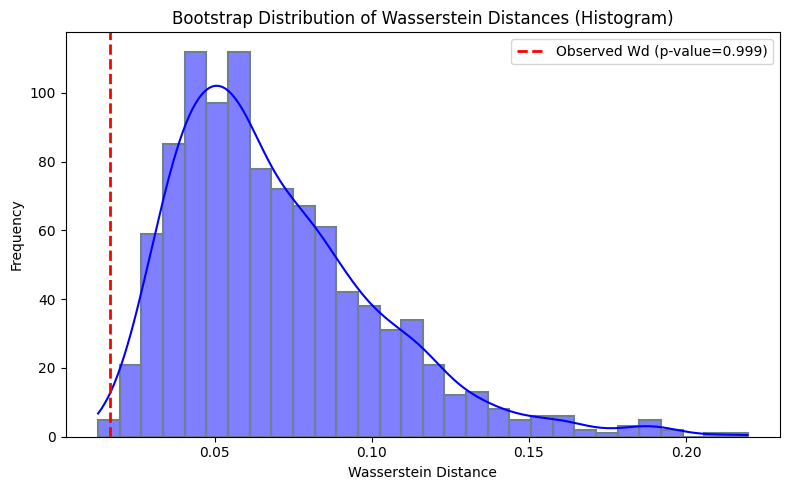

In [81]:
bins = np.linspace(min(fdf1.log_whiff.min(), fdf_predicted.log_whiff.min()),
                   max(fdf1.log_whiff.max(), fdf_predicted.log_whiff.max()), 20)

# Calculate histogram counts
true_hist, _ = np.histogram(fdf1.log_whiff, bins=bins, density=True)
pred_hist, _ = np.histogram(fdf_predicted.log_whiff, bins=bins, density=True)

# Calculate observed Wasserstein distance
observed_wd = wasserstein_distance(true_hist, pred_hist)

# Bootstrapping for histogram-based comparison
bootstrap_distances = bootstrap_wasserstein(true_hist, pred_hist, n_bootstraps=1000)
p_value = np.mean(np.array(bootstrap_distances) >= observed_wd)
# Plot bootstrap results
plt.figure(figsize=(8, 5))
sns.histplot(bootstrap_distances, bins=30, kde=True, color='blue', edgecolor='slategray', linewidth=1.5)
plt.axvline(observed_wd, color='red', linestyle='--', linewidth=2, label=f'Observed Wd (p-value={p_value:.3f})')
plt.title('Bootstrap Distribution of Wasserstein Distances (Histogram)')
plt.xlabel('Wasserstein Distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()